# 3D Primitive Fusion Languages

Lots of research papers often try to distill a given 3D shape into a set of primitives. These primitives are often simple shapes such as spheres, cylinders, and cubes. This notebooks shows how GeoLIPI can be used for such representations.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch as th
import time
import matplotlib.pyplot as plt

import geolipi.symbolic as gls
from geolipi.torch_compute.sphere_marcher import Renderer

dtype = th.float32
device = th.device("cuda")
resolution = (1024, 512)

In [2]:
# Just use the default settings in the renderer
renderer = Renderer(resolution=resolution, device=device, 
            dtype=dtype, unroll_expression=True, torch_compile=False)


Time taken: 2.936068534851074 seconds
Time taken: 5.064174652099609 seconds


(-0.5, 1023.5, 511.5, -0.5)

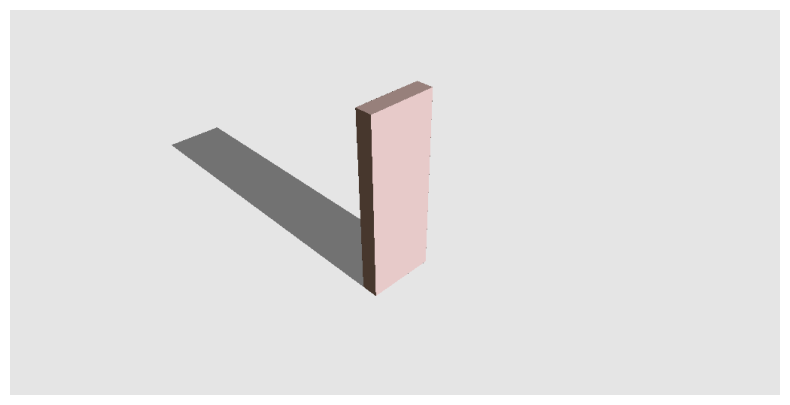

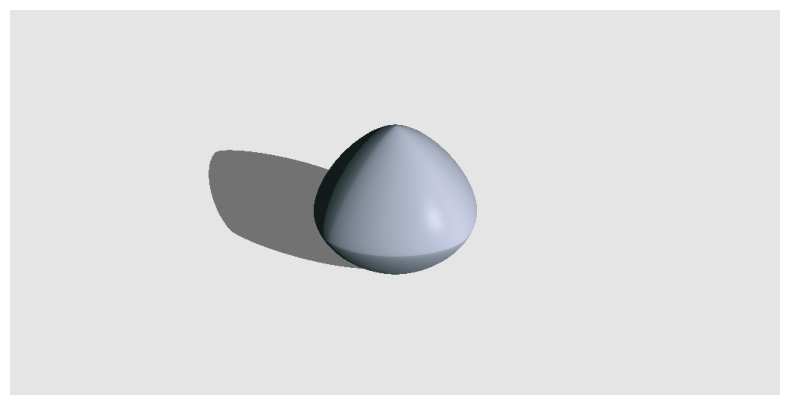

In [3]:
# Single Primitive Cuboids

simple_cuboid_expr = gls.Cuboid3D((0.1, 1.2, 0.4))
simple_cuboid_expr = simple_cuboid_expr.tensor().cuda()

start_time = time.time()
image = renderer.render(simple_cuboid_expr)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')

# Note that inexact SDFs can often fail to render properly. 
# Inexact SDFs are more useful for occupancy evaluation rather than rendering.

simple_quad_expr = gls.EulerRotate3D(gls.InexactSuperQuadrics3D((0.9, 0.9, 0.9), (1.5), (1.2)), (np.pi/2, 0, 0))
simple_quad_expr = simple_quad_expr.tensor().cuda()

start_time = time.time()
image = renderer.render(simple_quad_expr, finite_difference_epsilon=None)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')

Time taken: 4.099851608276367 seconds
Time taken: 12.531811952590942 seconds


(-0.5, 1023.5, 511.5, -0.5)

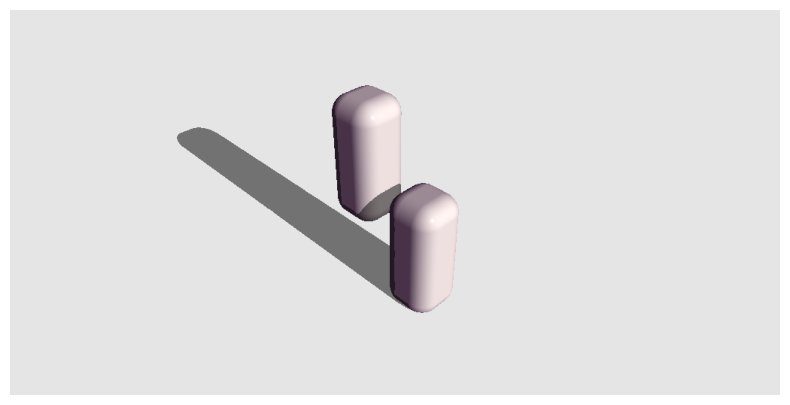

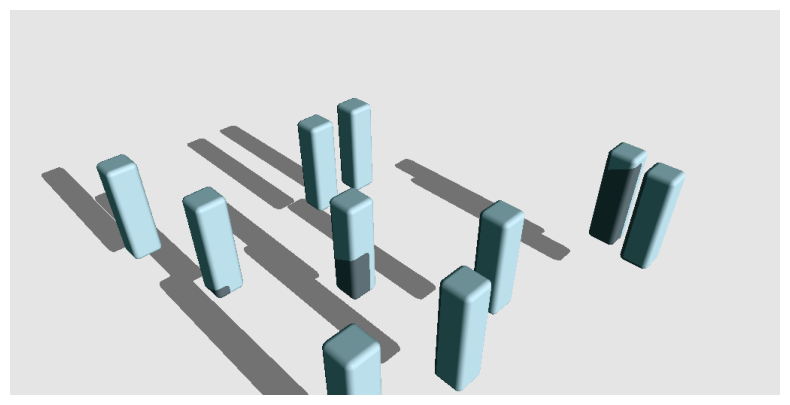

In [4]:
# Primitive fusion: Set of Cuboids - Single Hierarchy
cuboid_fusion_expr = gls.Union(
    gls.Translate3D(gls.RoundedBox3D((0.1, 0.5, 0.1), (0.2)), (0.4, 0.4, 0)),
    gls.Translate3D(gls.RoundedBox3D((0.1, 0.5, 0.1), (0.2)), (-0.4, -0.4, 0)),
)
cuboid_fusion_expr = cuboid_fusion_expr.tensor().cuda()
start_time = time.time()
image = renderer.render(cuboid_fusion_expr)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')

# longer expressions
N = 10
cuboid_list = []
for i in range(N):
    translate_param = (th.rand(3).cuda() - 0.5) * 4
    translate_param[1] = 0
    cuboid_list.append(gls.Translate3D(gls.RoundedBox3D((0.1, 0.5, 0.1), (0.05)), translate_param))
cuboid_fusion_expr = gls.Union(*cuboid_list)
cuboid_fusion_expr = cuboid_fusion_expr.tensor().cuda()
start_time = time.time()
image = renderer.render(cuboid_fusion_expr)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')


/opt/venv/lib/python3.10/site-packages/torch/_inductor/cudagraph_trees.py:2345: UserWarning: Unable to hit fast path of CUDAGraphs because of pending, uninvoked backwards. Consider running with torch.no_grad() or using torch.compiler.cudagraph_mark_step_begin() before each model invocation
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/torch/_inductor/cudagraph_trees.py:2345: UserWarning: Unable to hit fast path of CUDAGraphs because of pending, uninvoked backwards. Consider running with torch.no_grad() or using torch.compiler.cudagraph_mark_step_begin() before each model invocation
  warnings.warn(


Time taken with compilation:  8.356647729873657


(-0.5, 1023.5, 511.5, -0.5)

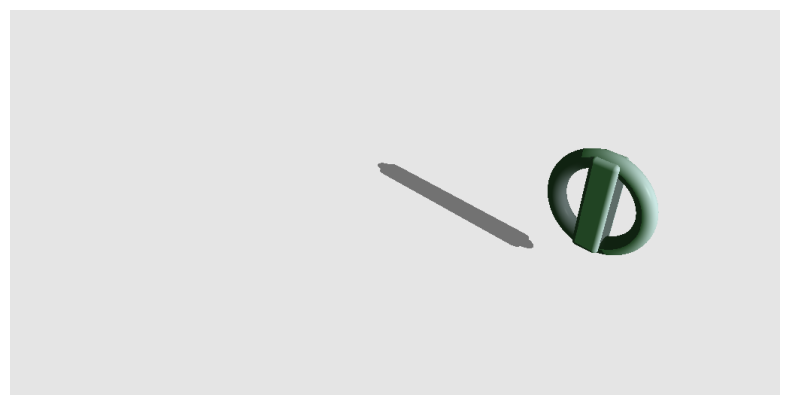

In [9]:
# Group them in a hierarchy of unions
# longer expressions
import time
expr = gls.RotationSymmetryY3D(
            gls.Translate3D(
                gls.Union(
                    gls.RoundedBox3D((0.1, 0.5, 0.1), (0.05,)),
                    gls.EulerRotate3D(gls.Torus3D((0.5, 0.1)), (np.pi/2, 0, 0))),
                (1.5, 0., 1.5)),
            np.pi/4, 8)
expr = expr.args[0].tensor().cuda()
# use compile_expression for faster rendering
renderer = Renderer(resolution=resolution, device=device, dtype=dtype, 
                    recursive_evaluator=False, unroll_expression=True, torch_compile=True)

st = time.time()
start_time = time.time()
image = renderer._compile_render_exprs(expr)
start_time = time.time()
image = renderer._render_precompiled(expr)
end_time = time.time()
print("Time taken with compilation: ", end_time - start_time)

plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')


skipping cudagraphs due to skipping cudagraphs due to cpu device (arg9_1). Found from : 
   File "/opt/venv/lib/python3.10/site-packages/torch/_dynamo/external_utils.py", line 40, in inner
    return fn(*args, **kwargs)
  File "<ast>", line 1, in compiled_fn
  File "/sensei-fs-3/users/aganeshan/projects/geolipi/geolipi/torch_compute/sdf_functions_3d.py", line 279, in sdf3d_hex_prism
    k = th.tensor([-COS_30, 0.5, TAN_30], device=points.device, dtype=th.float32)

skipping cudagraphs due to skipping cudagraphs due to cpu device (primals_10). Found from : 
   File "/opt/venv/lib/python3.10/site-packages/torch/_dynamo/external_utils.py", line 40, in inner
    return fn(*args, **kwargs)
  File "<ast>", line 1, in compiled_fn
  File "/sensei-fs-3/users/aganeshan/projects/geolipi/geolipi/torch_compute/sdf_functions_3d.py", line 279, in sdf3d_hex_prism
    k = th.tensor([-COS_30, 0.5, TAN_30], device=points.device, dtype=th.float32)

skipping cudagraphs due to skipping cudagraphs due to cpu 

Time taken: 10.167858839035034 seconds


(-0.5, 1023.5, 511.5, -0.5)

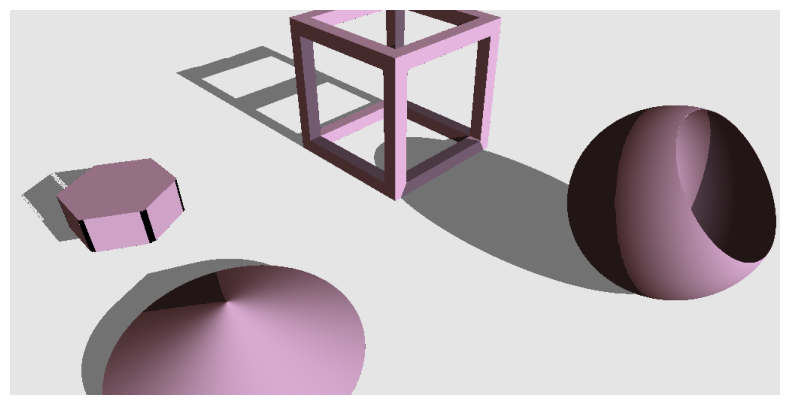

In [6]:
# Use Other Fancy Primitives:
fancy_expr = gls.Union(*[
    gls.Translate3D(gls.BoxFrame3D((1, 1, 1.), (0.1,)), (-2, 0, 2)),
    gls.Translate3D(gls.EulerRotate3D(gls.HexPrism3D((0.5, 0.2)),(-np.pi/2, 0, 0)), (-2, 0, -2)),
    gls.Translate3D(gls.EulerRotate3D(gls.DeathStar3D((1.0,), (0.8,), (0.4,)), (-np.pi/4, 0, np.pi/4)), (2, 0, 2)),
    gls.Translate3D(gls.EulerRotate3D(gls.SolidAngle3D((0.5,), (1.3, )), (0, 0, 0)), (0, 0, -2))

])
fancy_expr = fancy_expr.tensor().cuda()
image = renderer._compile_render_exprs(fancy_expr)
start_time = time.time()
image = renderer._render_precompiled(fancy_expr)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')